In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path

In [3]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import ImmunitySetter
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder


No --data argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/JUNE/data
No --configs argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/JUNE/june/configs


2022-03-08 11:17:31,721 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/UNGP-settlement-modelling-private/camp_data
2022-03-08 11:17:31,722 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/UNGP-settlement-modelling-private/configs_camps


In [4]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor

In [5]:
Results_Path = "results"

Config_File_Path = camp_configs_path / "config_demo.yaml"
Interactions_File_Path = camp_configs_path / "defaults/interaction/ContactInteraction_subgroups.yaml"
Policies_File_Path = camp_configs_path / "defaults/policy/simple_policy.yaml"
Hospitals_File_Path = camp_data_path / "input/hospitals/hospitals.csv"
comorbidity_multipliers_path = camp_configs_path / "defaults/comorbidities.yaml"
male_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_male_comorbidities.csv"
female_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_female_comorbidities.csv"

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [6]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2022-03-08 11:17:32,193 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [7]:
# populate empty world
populate_world(world)

In [8]:
# distribute people to households
distribute_people_to_households(world)

Distributing 468 people to CXB-219-001
Parents done
Kids done
All multigen adults done
All adults only houses done
Distributing 369 people to CXB-219-002
Parents done
Kids done
All multigen adults done
All adults only houses done
Distributing 331 people to CXB-219-003
Parents done
Kids done
All multigen adults done
All adults only houses done
Distributing 386 people to CXB-219-004
Parents done
Kids done
All multigen adults done
All adults only houses done
Distributing 313 people to CXB-219-005
Parents done
Kids done
All multigen adults done
All adults only houses done
Distributing 331 people to CXB-219-006
Parents done
Kids done
All multigen adults done
All adults only houses done
Distributing 259 people to CXB-219-007
Parents done
Kids done
All multigen adults done
All adults only houses done
Distributing 350 people to CXB-219-009
Parents done
Kids done
All multigen adults done
All adults only houses done
Distributing 274 people to CXB-219-010
Parents done
Kids done
All multigen adult

In [9]:
# distirbute hospitals
hospitals = Hospitals.from_file(
    filename=Hospitals_File_Path
)
for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)
hospital_distributor.distribute_medics_from_world(world.people)

2022-03-08 11:17:34,631 - hospitals - INFO - There are 8 hospitals in the world.


In [10]:
PumpLatrines.Get_Interaction(Interactions_File_Path)
world.pump_latrines = PumpLatrines.for_areas(world.areas)

PlayGroups.Get_Interaction(Interactions_File_Path)
world.play_groups = PlayGroups.for_areas(world.areas)

DistributionCenters.Get_Interaction(Interactions_File_Path)
world.distribution_centers = DistributionCenters.for_areas(world.areas)

Communals.Get_Interaction(Interactions_File_Path)
world.communals = Communals.for_areas(world.areas)

FemaleCommunals.Get_Interaction(Interactions_File_Path)
world.female_communals = FemaleCommunals.for_areas(world.areas)

Religiouss.Get_Interaction(Interactions_File_Path)
world.religiouss = Religiouss.for_areas(world.areas)

EVouchers.Get_Interaction(Interactions_File_Path)
world.e_vouchers = EVouchers.for_areas(world.areas)

NFDistributionCenters.Get_Interaction(Interactions_File_Path)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

2022-03-08 11:17:34,758 - social_venue - INFO - Domain 0 has 225 pump_latrines(s)
2022-03-08 11:17:34,838 - social_venue - INFO - Domain 0 has 536 play_groups(s)
2022-03-08 11:17:34,863 - social_venue - INFO - Domain 0 has 7 distribution_centers(s)
2022-03-08 11:17:34,929 - social_venue - INFO - Domain 0 has 125 communals(s)
2022-03-08 11:17:34,973 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2022-03-08 11:17:35,798 - social_venue - INFO - Domain 0 has 2064 religiouss(s)
2022-03-08 11:17:35,825 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2022-03-08 11:17:35,861 - social_venue - INFO - Domain 0 has 36 n_f_distribution_centers(s)


In [11]:
world.cemeteries = Cemeteries()

## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [12]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [13]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [14]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [15]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [16]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [17]:
sample_sexes[:5], sample_ages[:5]

(['m', 'f', 'f', 'f', 'f'], [61, 18, 36, 44, 59])

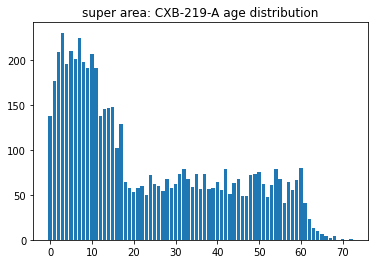

In [18]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [19]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

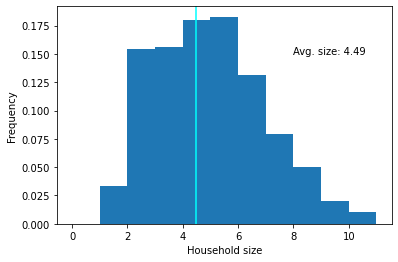

In [20]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [21]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

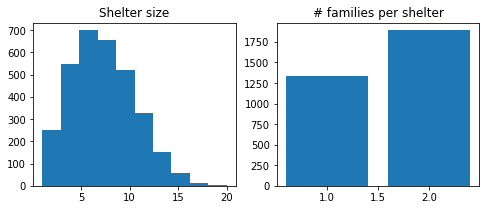

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [23]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [24]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 4 pumps and latrines in area CXB-219-001


### Distribution centers

In [25]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [26]:
distribution_centers[0].coordinates

array([21.21176333, 92.13597667])

### Non-food Distribution centers

In [27]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [28]:
non_food_distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### E-Voucher outlets

In [29]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [30]:
e_voucher_outlets[0].coordinates

array([21.21176333, 92.13597667])

### Communal spaces

In [31]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [32]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [33]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [34]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [35]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [36]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [37]:
selector = InfectionSelector.from_file()

In [38]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [39]:
interaction = Interaction.from_file(
    config_filename=Interactions_File_Path,
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [40]:
policies = Policies.from_file(
        Policies_File_Path,
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [41]:
policies.policies

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [42]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-05-24"
)

In [43]:
infection_seeds = InfectionSeeds([infection_seed])

In [44]:
immunity_setter = ImmunitySetter.from_file_with_comorbidities(
    comorbidity_multipliers_path= comorbidity_multipliers_path,
    male_comorbidity_reference_prevalence_path= male_comorbidity_reference_prevalence_path,
    female_comorbidity_reference_prevalence_path = female_comorbidity_reference_prevalence_path,   
)

In [45]:
epidemiology = Epidemiology(
    infection_selectors=selectors,
    infection_seeds=infection_seeds,
    immunity_setter=immunity_setter,
)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [46]:
CONFIG_PATH = Config_File_Path

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [47]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
leisure.leisure_distributors = {}
leisure.leisure_distributors["pump_latrine"] = PumpLatrineDistributor.from_config(
    world.pump_latrines
)
leisure.leisure_distributors["play_group"] = PlayGroupDistributor.from_config(
    world.play_groups
)
leisure.leisure_distributors[
    "distribution_center"
] = DistributionCenterDistributor.from_config(world.distribution_centers)
leisure.leisure_distributors["communal"] = CommunalDistributor.from_config(
    world.communals
)
leisure.leisure_distributors[
    "female_communal"
] = FemaleCommunalDistributor.from_config(world.female_communals)
leisure.leisure_distributors["religious"] = ReligiousDistributor.from_config(
    world.religiouss
)
leisure.leisure_distributors["e_voucher"] = EVoucherDistributor.from_config(
    world.e_vouchers
)
leisure.leisure_distributors[
    "n_f_distribution_center"
] = NFDistributionCenterDistributor.from_config(world.n_f_distribution_centers)
leisure.leisure_distributors[
    "shelters_visits"
] = SheltersVisitsDistributor.from_config()
leisure.leisure_distributors["shelters_visits"].link_shelters_to_shelters(
    world.super_areas
)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2022-03-08 11:17:37,261 - leisure - INFO - Linking households and care homes for visits
2022-03-08 11:17:37,261 - leisure - INFO - Done
2022-03-08 11:17:37,262 - leisure - INFO - Distributing social venues to areas
2022-03-08 11:17:37,262 - leisure - INFO - Distributed in 0 of 65 areas.
2022-03-08 11:17:37,336 - leisure - INFO - Distributed in 65 of 65 areas.


# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [48]:
record = Record(
    record_path=Results_Path, 
    record_static_data=True
)


The simulator is defined with all the different necessary components we have built up so far

In [49]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    tracker=None,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)

Finally we can run a small simualation

In [50]:
%%time
simulator.run()

2022-03-08 11:17:37,558 - simulator - INFO - Starting simulation for 70 days at day 2020-05-24 00:00:00,to run for 70 days
2022-03-08 11:17:37,873 - rank - INFO - Next timestep
2022-03-08 11:17:37,873 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:17:37,988 - rank - INFO - Rank 0 -- move_people -- 0.11390093498630449
2022-03-08 11:17:37,988 - rank - INFO - Rank 0 -- move_people_waiting -- 6.342015694826841e-06
2022-03-08 11:17:37,988 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.362998202443123e-06,1.9073486328125e-06 - 2020-05-24 00:00:00
2022-03-08 11:17:37,992 - simulator - INFO - Info for rank 0, Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 217
2022-03-08 11:17:38,049 - rank - INFO - Rank 0 -- interaction -- 0.06047611898975447
2022-03-08 11:17:38,050 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002801179653033614,0.00028014183044433594 - 2020-05-24 00:00:00
2022-03-08 11:17:38,152

2022-03-08 11:17:42,116 - simulator - INFO - Info for rank 0, Date = 2020-05-25 02:00:00, number of deaths =  0, number of infected = 256
2022-03-08 11:17:42,196 - rank - INFO - Rank 0 -- interaction -- 0.08365230297204107
2022-03-08 11:17:42,200 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007367969956248999,0.0007367134094238281 - 2020-05-25 02:00:00
2022-03-08 11:17:42,227 - rank - INFO - Rank 0 -- interaction_waiting -- 6.3979532569646835e-06
2022-03-08 11:17:42,238 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010512934997677803,0.010513544082641602 - 2020-05-25 02:00:00

2022-03-08 11:17:42,239 - rank - INFO - Next timestep
2022-03-08 11:17:42,240 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:17:42,731 - rank - INFO - Rank 0 -- move_people -- 0.49049026699503884
2022-03-08 11:17:42,732 - rank - INFO - Rank 0 -- move_people_waiting -- 5.331996362656355e-06
2022-03-08 11:17:42,732 - activity_manager - INFO - CMS: Peo

2022-03-08 11:17:45,934 - rank - INFO - Next timestep
2022-03-08 11:17:45,935 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:17:46,439 - rank - INFO - Rank 0 -- move_people -- 0.5036846830043942
2022-03-08 11:17:46,439 - rank - INFO - Rank 0 -- move_people_waiting -- 5.637994036078453e-06
2022-03-08 11:17:46,440 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4830223992466927e-06,2.384185791015625e-06 - 2020-05-26 06:00:00
2022-03-08 11:17:46,443 - simulator - INFO - Info for rank 0, Date = 2020-05-26 06:00:00, number of deaths =  0, number of infected = 365
2022-03-08 11:17:46,532 - rank - INFO - Rank 0 -- interaction -- 0.09225270798197016
2022-03-08 11:17:46,538 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006771649932488799,0.0006771087646484375 - 2020-05-26 06:00:00
2022-03-08 11:17:46,565 - rank - INFO - Rank 0 -- interaction_waiting -- 6.295042112469673e-06
2022-03-08 11:17:46,576 - simulator - INFO - CMS: 

2022-03-08 11:17:50,478 - rank - INFO - Rank 0 -- interaction -- 0.10889307101024315
2022-03-08 11:17:50,486 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024987198412418365,0.0002493858337402344 - 2020-05-27 08:00:00
2022-03-08 11:17:50,513 - rank - INFO - Rank 0 -- interaction_waiting -- 7.110997103154659e-06
2022-03-08 11:17:50,524 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011161661997903138,0.01116180419921875 - 2020-05-27 08:00:00

2022-03-08 11:17:50,526 - rank - INFO - Next timestep
2022-03-08 11:17:50,526 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:17:50,653 - rank - INFO - Rank 0 -- move_people -- 0.12631998298456892
2022-03-08 11:17:50,654 - rank - INFO - Rank 0 -- move_people_waiting -- 5.849986337125301e-06
2022-03-08 11:17:50,654 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3050233721733093e-06,2.384185791015625e-06 - 2020-05-27 10:00:00
2022-03-08 11:17:50,658 - simulator - INFO - Inf

2022-03-08 11:17:54,494 - rank - INFO - Rank 0 -- move_people -- 0.12902639503590763
2022-03-08 11:17:54,494 - rank - INFO - Rank 0 -- move_people_waiting -- 6.384041626006365e-06
2022-03-08 11:17:54,495 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.774992026388645e-06,2.6226043701171875e-06 - 2020-05-29 00:00:00
2022-03-08 11:17:54,499 - simulator - INFO - Info for rank 0, Date = 2020-05-29 00:00:00, number of deaths =  0, number of infected = 809
2022-03-08 11:17:54,574 - rank - INFO - Rank 0 -- interaction -- 0.07836559502175078
2022-03-08 11:17:54,584 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003702469985000789,0.00036978721618652344 - 2020-05-29 00:00:00
2022-03-08 11:17:54,614 - rank - INFO - Rank 0 -- interaction_waiting -- 6.553018465638161e-06
2022-03-08 11:17:54,625 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011375546979252249,0.011376142501831055 - 2020-05-29 00:00:00

2022-03-08 11:17:54,626 - rank - INFO - Next timestep
2022-

2022-03-08 11:17:58,599 - rank - INFO - Rank 0 -- interaction_waiting -- 7.526949048042297e-06
2022-03-08 11:17:58,610 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011568780988454819,0.011568784713745117 - 2020-05-30 03:00:00

2022-03-08 11:17:58,612 - rank - INFO - Next timestep
2022-03-08 11:17:58,612 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:17:59,110 - rank - INFO - Rank 0 -- move_people -- 0.49670912796864286
2022-03-08 11:17:59,110 - rank - INFO - Rank 0 -- move_people_waiting -- 6.636022590100765e-06
2022-03-08 11:17:59,111 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.2420426830649376e-06,2.1457672119140625e-06 - 2020-05-30 05:00:00
2022-03-08 11:17:59,114 - simulator - INFO - Info for rank 0, Date = 2020-05-30 05:00:00, number of deaths =  0, number of infected = 1069
2022-03-08 11:17:59,242 - rank - INFO - Rank 0 -- interaction -- 0.13136308797402307
2022-03-08 11:17:59,252 - epidemiology - INFO - CMS: Infecti

2022-03-08 11:18:03,135 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.842978574335575e-06,2.6226043701171875e-06 - 2020-05-31 07:00:00
2022-03-08 11:18:03,139 - simulator - INFO - Info for rank 0, Date = 2020-05-31 07:00:00, number of deaths =  0, number of infected = 1349
2022-03-08 11:18:03,255 - rank - INFO - Rank 0 -- interaction -- 0.11975341802462935
2022-03-08 11:18:03,265 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00032774999272078276,0.0003275871276855469 - 2020-05-31 07:00:00
2022-03-08 11:18:03,292 - rank - INFO - Rank 0 -- interaction_waiting -- 5.872978363186121e-06
2022-03-08 11:18:03,302 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009860287012998015,0.00986027717590332 - 2020-05-31 07:00:00

2022-03-08 11:18:03,303 - rank - INFO - Next timestep
2022-03-08 11:18:03,304 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:03,812 - rank - INFO - Rank 0 -- move_people -- 0.507647430000361
2022-0

2022-03-08 11:18:07,300 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009808912000153214,0.009809255599975586 - 2020-06-01 08:00:00

2022-03-08 11:18:07,302 - rank - INFO - Next timestep
2022-03-08 11:18:07,302 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:07,429 - rank - INFO - Rank 0 -- move_people -- 0.12660194199997932
2022-03-08 11:18:07,430 - rank - INFO - Rank 0 -- move_people_waiting -- 5.553010851144791e-06
2022-03-08 11:18:07,430 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.668995875865221e-06,2.6226043701171875e-06 - 2020-06-01 10:00:00
2022-03-08 11:18:07,434 - simulator - INFO - Info for rank 0, Date = 2020-06-01 10:00:00, number of deaths =  0, number of infected = 1673
2022-03-08 11:18:07,523 - rank - INFO - Rank 0 -- interaction -- 0.0926878770114854
2022-03-08 11:18:07,560 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00015830795746296644,0.00015807151794433594 - 2020-06-01 10:00:00
202

2022-03-08 11:18:11,341 - simulator - INFO - Info for rank 0, Date = 2020-06-03 00:00:00, number of deaths =  0, number of infected = 2111
2022-03-08 11:18:11,429 - rank - INFO - Rank 0 -- interaction -- 0.0918455760111101
2022-03-08 11:18:11,439 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017358799232169986,0.00017333030700683594 - 2020-06-03 00:00:00
2022-03-08 11:18:11,469 - rank - INFO - Rank 0 -- interaction_waiting -- 6.492016837000847e-06
2022-03-08 11:18:11,478 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009299550030846149,0.009299755096435547 - 2020-06-03 00:00:00

2022-03-08 11:18:11,480 - rank - INFO - Next timestep
2022-03-08 11:18:11,481 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:12,015 - rank - INFO - Rank 0 -- move_people -- 0.5333387900027446
2022-03-08 11:18:12,015 - rank - INFO - Rank 0 -- move_people_waiting -- 5.679961759597063e-06
2022-03-08 11:18:12,016 - activity_manager - INFO - CMS: Peo

2022-03-08 11:18:15,822 - rank - INFO - Next timestep
2022-03-08 11:18:15,823 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:16,464 - rank - INFO - Rank 0 -- move_people -- 0.6405045359861106
2022-03-08 11:18:16,465 - rank - INFO - Rank 0 -- move_people_waiting -- 8.106988389045e-06
2022-03-08 11:18:16,465 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9570073820650578e-06,2.86102294921875e-06 - 2020-06-04 04:00:00
2022-03-08 11:18:16,470 - simulator - INFO - Info for rank 0, Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 2533
2022-03-08 11:18:16,613 - rank - INFO - Rank 0 -- interaction -- 0.14763608801877126
2022-03-08 11:18:16,625 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018403801368549466,0.00018405914306640625 - 2020-06-04 04:00:00
2022-03-08 11:18:16,655 - rank - INFO - Rank 0 -- interaction_waiting -- 5.258014425635338e-06
2022-03-08 11:18:16,668 - simulator - INFO - CMS: T

2022-03-08 11:18:21,178 - rank - INFO - Rank 0 -- interaction -- 0.17318237497238442
2022-03-08 11:18:21,202 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00040144595550373197,0.0004010200500488281 - 2020-06-05 06:00:00
2022-03-08 11:18:21,240 - rank - INFO - Rank 0 -- interaction_waiting -- 6.299000233411789e-06
2022-03-08 11:18:21,250 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010221219970844686,0.01022195816040039 - 2020-06-05 06:00:00

2022-03-08 11:18:21,252 - rank - INFO - Next timestep
2022-03-08 11:18:21,252 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:21,828 - rank - INFO - Rank 0 -- move_people -- 0.5751309210318141
2022-03-08 11:18:21,829 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6599813029170036e-06
2022-03-08 11:18:21,829 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.529995981603861e-06,2.1457672119140625e-06 - 2020-06-05 08:00:00
2022-03-08 11:18:21,834 - simulator - INFO - Inf

2022-03-08 11:18:26,010 - rank - INFO - Rank 0 -- move_people -- 0.12886780296685174
2022-03-08 11:18:26,011 - rank - INFO - Rank 0 -- move_people_waiting -- 5.311041604727507e-06
2022-03-08 11:18:26,013 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.87697184830904e-06,2.384185791015625e-06 - 2020-06-06 11:00:00
2022-03-08 11:18:26,017 - simulator - INFO - Info for rank 0, Date = 2020-06-06 11:00:00, number of deaths =  1, number of infected = 3617
2022-03-08 11:18:26,147 - rank - INFO - Rank 0 -- interaction -- 0.13397328899009153
2022-03-08 11:18:26,203 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003852719673886895,0.000385284423828125 - 2020-06-06 11:00:00
2022-03-08 11:18:26,239 - rank - INFO - Rank 0 -- interaction_waiting -- 6.240967195481062e-06
2022-03-08 11:18:26,250 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010238407005090266,0.010238885879516602 - 2020-06-06 11:00:00

2022-03-08 11:18:26,251 - rank - INFO - Next timestep
2022-03-

2022-03-08 11:18:30,343 - rank - INFO - Rank 0 -- interaction_waiting -- 6.445043254643679e-06
2022-03-08 11:18:30,352 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009376701025757939,0.009376764297485352 - 2020-06-08 00:00:00

2022-03-08 11:18:30,354 - rank - INFO - Next timestep
2022-03-08 11:18:30,355 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:30,863 - rank - INFO - Rank 0 -- move_people -- 0.5080600039800629
2022-03-08 11:18:30,864 - rank - INFO - Rank 0 -- move_people_waiting -- 4.7800131142139435e-06
2022-03-08 11:18:30,864 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8720241971313953e-06,2.86102294921875e-06 - 2020-06-08 02:00:00
2022-03-08 11:18:30,868 - simulator - INFO - Info for rank 0, Date = 2020-06-08 02:00:00, number of deaths =  1, number of infected = 4460
2022-03-08 11:18:31,030 - rank - INFO - Rank 0 -- interaction -- 0.16527871205471456
2022-03-08 11:18:31,048 - epidemiology - INFO - CMS: Infection

2022-03-08 11:18:35,567 - simulator - INFO - Info for rank 0, Date = 2020-06-09 04:00:00, number of deaths =  2, number of infected = 5120
2022-03-08 11:18:35,775 - rank - INFO - Rank 0 -- interaction -- 0.2125255879946053
2022-03-08 11:18:35,807 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018987699877470732,0.00018930435180664062 - 2020-06-09 04:00:00
2022-03-08 11:18:35,867 - rank - INFO - Rank 0 -- interaction_waiting -- 5.593989044427872e-06
2022-03-08 11:18:35,878 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010484569997061044,0.010484695434570312 - 2020-06-09 04:00:00

2022-03-08 11:18:35,879 - rank - INFO - Next timestep
2022-03-08 11:18:35,880 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:36,427 - rank - INFO - Rank 0 -- move_people -- 0.5463245360297151
2022-03-08 11:18:36,428 - rank - INFO - Rank 0 -- move_people_waiting -- 5.792011506855488e-06
2022-03-08 11:18:36,428 - activity_manager - INFO - CMS: Peo

2022-03-08 11:18:41,674 - rank - INFO - Next timestep
2022-03-08 11:18:41,675 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:42,285 - rank - INFO - Rank 0 -- move_people -- 0.6093063430162147
2022-03-08 11:18:42,286 - rank - INFO - Rank 0 -- move_people_waiting -- 7.853028364479542e-06
2022-03-08 11:18:42,286 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9790098778903484e-06,2.6226043701171875e-06 - 2020-06-10 08:00:00
2022-03-08 11:18:42,291 - simulator - INFO - Info for rank 0, Date = 2020-06-10 08:00:00, number of deaths =  2, number of infected = 5908
2022-03-08 11:18:42,531 - rank - INFO - Rank 0 -- interaction -- 0.24443759402493015
2022-03-08 11:18:42,567 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024049001513049006,0.000240325927734375 - 2020-06-10 08:00:00
2022-03-08 11:18:42,630 - rank - INFO - Rank 0 -- interaction_waiting -- 6.043992470949888e-06
2022-03-08 11:18:42,643 - simulator - INFO - CMS

2022-03-08 11:18:48,676 - rank - INFO - Rank 0 -- interaction -- 0.2757407000171952
2022-03-08 11:18:48,929 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001919200294651091,0.0001914501190185547 - 2020-06-11 10:00:00
2022-03-08 11:18:48,997 - rank - INFO - Rank 0 -- interaction_waiting -- 6.732007022947073e-06
2022-03-08 11:18:49,008 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011089614999946207,0.011089563369750977 - 2020-06-11 10:00:00

2022-03-08 11:18:49,010 - rank - INFO - Next timestep
2022-03-08 11:18:49,011 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:18:49,214 - rank - INFO - Rank 0 -- move_people -- 0.20196039997972548
2022-03-08 11:18:49,214 - rank - INFO - Rank 0 -- move_people_waiting -- 5.4460251703858376e-06
2022-03-08 11:18:49,215 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.238965291529894e-06,3.0994415283203125e-06 - 2020-06-12 00:00:00
2022-03-08 11:18:49,220 - simulator - INFO - Inf

2022-03-08 11:18:55,143 - rank - INFO - Rank 0 -- move_people -- 0.5748928639804944
2022-03-08 11:18:55,144 - rank - INFO - Rank 0 -- move_people_waiting -- 5.250039976090193e-06
2022-03-08 11:18:55,144 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.48901778832078e-06,2.384185791015625e-06 - 2020-06-13 03:00:00
2022-03-08 11:18:55,150 - simulator - INFO - Info for rank 0, Date = 2020-06-13 03:00:00, number of deaths =  2, number of infected = 7973
2022-03-08 11:18:55,344 - rank - INFO - Rank 0 -- interaction -- 0.1996738889720291
2022-03-08 11:18:55,384 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00016899697948247194,0.00016880035400390625 - 2020-06-13 03:00:00
2022-03-08 11:18:55,444 - rank - INFO - Rank 0 -- interaction_waiting -- 5.531997885555029e-06
2022-03-08 11:18:55,453 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009281211998313665,0.009281635284423828 - 2020-06-13 03:00:00

2022-03-08 11:18:55,455 - rank - INFO - Next timestep
2022-03

2022-03-08 11:19:01,119 - rank - INFO - Rank 0 -- interaction_waiting -- 6.901042070239782e-06
2022-03-08 11:19:01,129 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009349269035737962,0.00934910774230957 - 2020-06-14 05:00:00

2022-03-08 11:19:01,130 - rank - INFO - Next timestep
2022-03-08 11:19:01,131 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:01,712 - rank - INFO - Rank 0 -- move_people -- 0.5808399330126122
2022-03-08 11:19:01,713 - rank - INFO - Rank 0 -- move_people_waiting -- 4.4790212996304035e-06
2022-03-08 11:19:01,714 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.23000131174922e-06,2.86102294921875e-06 - 2020-06-14 07:00:00
2022-03-08 11:19:01,720 - simulator - INFO - Info for rank 0, Date = 2020-06-14 07:00:00, number of deaths =  2, number of infected = 8991
2022-03-08 11:19:01,927 - rank - INFO - Rank 0 -- interaction -- 0.21272916404996067
2022-03-08 11:19:01,961 - epidemiology - INFO - CMS: Infection CO

2022-03-08 11:19:07,190 - simulator - INFO - Info for rank 0, Date = 2020-06-15 08:00:00, number of deaths =  3, number of infected = 9877
2022-03-08 11:19:07,503 - rank - INFO - Rank 0 -- interaction -- 0.31951601698528975
2022-03-08 11:19:07,545 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00037143699591979384,0.0003712177276611328 - 2020-06-15 08:00:00
2022-03-08 11:19:07,620 - rank - INFO - Rank 0 -- interaction_waiting -- 6.293004844337702e-06
2022-03-08 11:19:07,631 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011725686024874449,0.01172637939453125 - 2020-06-15 08:00:00

2022-03-08 11:19:07,633 - rank - INFO - Next timestep
2022-03-08 11:19:07,633 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:07,785 - rank - INFO - Rank 0 -- move_people -- 0.15098854497773573
2022-03-08 11:19:07,785 - rank - INFO - Rank 0 -- move_people_waiting -- 5.908019375056028e-06
2022-03-08 11:19:07,786 - activity_manager - INFO - CMS: Peo

2022-03-08 11:19:12,887 - rank - INFO - Next timestep
2022-03-08 11:19:12,887 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:13,037 - rank - INFO - Rank 0 -- move_people -- 0.14878557104384527
2022-03-08 11:19:13,037 - rank - INFO - Rank 0 -- move_people_waiting -- 5.494977813214064e-06
2022-03-08 11:19:13,038 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7320347726345062e-06,2.6226043701171875e-06 - 2020-06-17 00:00:00
2022-03-08 11:19:13,046 - simulator - INFO - Info for rank 0, Date = 2020-06-17 00:00:00, number of deaths =  3, number of infected = 11196
2022-03-08 11:19:13,210 - rank - INFO - Rank 0 -- interaction -- 0.17213624197756872
2022-03-08 11:19:13,233 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020215596305206418,0.00020194053649902344 - 2020-06-17 00:00:00
2022-03-08 11:19:13,305 - rank - INFO - Rank 0 -- interaction_waiting -- 5.784968379884958e-06
2022-03-08 11:19:13,314 - simulator - INFO -

2022-03-08 11:19:18,674 - rank - INFO - Rank 0 -- interaction -- 0.18737438396783546
2022-03-08 11:19:18,704 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003994000144302845,0.0003991127014160156 - 2020-06-18 02:00:00
2022-03-08 11:19:18,778 - rank - INFO - Rank 0 -- interaction_waiting -- 5.140027496963739e-06
2022-03-08 11:19:18,787 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.008993501018267125,0.008993864059448242 - 2020-06-18 02:00:00

2022-03-08 11:19:18,788 - rank - INFO - Next timestep
2022-03-08 11:19:18,789 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:19,414 - rank - INFO - Rank 0 -- move_people -- 0.6240877829841338
2022-03-08 11:19:19,415 - rank - INFO - Rank 0 -- move_people_waiting -- 8.5500068962574e-06
2022-03-08 11:19:19,415 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.427034243941307e-06,3.0994415283203125e-06 - 2020-06-18 04:00:00
2022-03-08 11:19:19,422 - simulator - INFO - Info f

2022-03-08 11:19:25,087 - rank - INFO - Rank 0 -- move_people -- 0.5884945519501343
2022-03-08 11:19:25,087 - rank - INFO - Rank 0 -- move_people_waiting -- 5.797017365694046e-06
2022-03-08 11:19:25,088 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5859917514026165e-06,2.384185791015625e-06 - 2020-06-19 06:00:00
2022-03-08 11:19:25,093 - simulator - INFO - Info for rank 0, Date = 2020-06-19 06:00:00, number of deaths =  4, number of infected = 12921
2022-03-08 11:19:25,284 - rank - INFO - Rank 0 -- interaction -- 0.19584773597307503
2022-03-08 11:19:25,316 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004133990150876343,0.0004131793975830078 - 2020-06-19 06:00:00
2022-03-08 11:19:25,400 - rank - INFO - Rank 0 -- interaction_waiting -- 5.092006176710129e-06
2022-03-08 11:19:25,409 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00914080097572878,0.009141206741333008 - 2020-06-19 06:00:00

2022-03-08 11:19:25,411 - rank - INFO - Next timestep
2022-0

2022-03-08 11:19:31,004 - rank - INFO - Rank 0 -- interaction_waiting -- 5.227979272603989e-06
2022-03-08 11:19:31,013 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009010264999233186,0.009010791778564453 - 2020-06-20 09:00:00

2022-03-08 11:19:31,015 - rank - INFO - Next timestep
2022-03-08 11:19:31,015 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:31,166 - rank - INFO - Rank 0 -- move_people -- 0.14963139197789133
2022-03-08 11:19:31,166 - rank - INFO - Rank 0 -- move_people_waiting -- 5.866051651537418e-06
2022-03-08 11:19:31,166 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7199857868254185e-06,2.384185791015625e-06 - 2020-06-20 11:00:00
2022-03-08 11:19:31,173 - simulator - INFO - Info for rank 0, Date = 2020-06-20 11:00:00, number of deaths =  4, number of infected = 13742
2022-03-08 11:19:31,367 - rank - INFO - Rank 0 -- interaction -- 0.20033261697972193
2022-03-08 11:19:31,479 - epidemiology - INFO - CMS: Infecti

2022-03-08 11:19:36,162 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.460030373185873e-06,2.384185791015625e-06 - 2020-06-22 00:00:00
2022-03-08 11:19:36,167 - simulator - INFO - Info for rank 0, Date = 2020-06-22 00:00:00, number of deaths =  6, number of infected = 14543
2022-03-08 11:19:36,335 - rank - INFO - Rank 0 -- interaction -- 0.1718774589826353
2022-03-08 11:19:36,354 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004019030020572245,0.0004012584686279297 - 2020-06-22 00:00:00
2022-03-08 11:19:36,444 - rank - INFO - Rank 0 -- interaction_waiting -- 5.563022568821907e-06
2022-03-08 11:19:36,454 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009655950008891523,0.009656190872192383 - 2020-06-22 00:00:00

2022-03-08 11:19:36,455 - rank - INFO - Next timestep
2022-03-08 11:19:36,456 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:37,086 - rank - INFO - Rank 0 -- move_people -- 0.6290420739678666
2022-0

2022-03-08 11:19:41,793 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009223197004757822,0.009223461151123047 - 2020-06-23 02:00:00

2022-03-08 11:19:41,794 - rank - INFO - Next timestep
2022-03-08 11:19:41,794 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:42,363 - rank - INFO - Rank 0 -- move_people -- 0.5676263790228404
2022-03-08 11:19:42,363 - rank - INFO - Rank 0 -- move_people_waiting -- 5.7229772210121155e-06
2022-03-08 11:19:42,363 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6730122044682503e-06,2.384185791015625e-06 - 2020-06-23 04:00:00
2022-03-08 11:19:42,369 - simulator - INFO - Info for rank 0, Date = 2020-06-23 04:00:00, number of deaths =  7, number of infected = 15036
2022-03-08 11:19:42,540 - rank - INFO - Rank 0 -- interaction -- 0.17656903300667182
2022-03-08 11:19:42,561 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003199409693479538,0.00031948089599609375 - 2020-06-23 04:00:00
20

2022-03-08 11:19:48,359 - simulator - INFO - Info for rank 0, Date = 2020-06-24 06:00:00, number of deaths =  7, number of infected = 15356
2022-03-08 11:19:48,546 - rank - INFO - Rank 0 -- interaction -- 0.190877219021786
2022-03-08 11:19:48,571 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017544894944876432,0.00017523765563964844 - 2020-06-24 06:00:00
2022-03-08 11:19:48,668 - rank - INFO - Rank 0 -- interaction_waiting -- 5.0639500841498375e-06
2022-03-08 11:19:48,678 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009320275974459946,0.009320497512817383 - 2020-06-24 06:00:00

2022-03-08 11:19:48,679 - rank - INFO - Next timestep
2022-03-08 11:19:48,680 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:49,267 - rank - INFO - Rank 0 -- move_people -- 0.5868681570282206
2022-03-08 11:19:49,268 - rank - INFO - Rank 0 -- move_people_waiting -- 3.663997631520033e-06
2022-03-08 11:19:49,268 - activity_manager - INFO - CMS: Pe

2022-03-08 11:19:53,921 - rank - INFO - Next timestep
2022-03-08 11:19:53,922 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:19:54,082 - rank - INFO - Rank 0 -- move_people -- 0.1595638960134238
2022-03-08 11:19:54,082 - rank - INFO - Rank 0 -- move_people_waiting -- 5.511974450200796e-06
2022-03-08 11:19:54,083 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.163993824273348e-06,3.0994415283203125e-06 - 2020-06-25 10:00:00
2022-03-08 11:19:54,088 - simulator - INFO - Info for rank 0, Date = 2020-06-25 10:00:00, number of deaths =  7, number of infected = 15717
2022-03-08 11:19:54,281 - rank - INFO - Rank 0 -- interaction -- 0.19793532398762181
2022-03-08 11:19:54,357 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000381280027795583,0.0003807544708251953 - 2020-06-25 10:00:00
2022-03-08 11:19:54,454 - rank - INFO - Rank 0 -- interaction_waiting -- 5.559995770454407e-06
2022-03-08 11:19:54,464 - simulator - INFO - CMS:

2022-03-08 11:19:59,481 - rank - INFO - Rank 0 -- interaction -- 0.1777780709671788
2022-03-08 11:19:59,502 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00038484897231683135,0.0003840923309326172 - 2020-06-27 00:00:00
2022-03-08 11:19:59,601 - rank - INFO - Rank 0 -- interaction_waiting -- 5.482987035065889e-06
2022-03-08 11:19:59,610 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.008929591975174844,0.008929729461669922 - 2020-06-27 00:00:00

2022-03-08 11:19:59,611 - rank - INFO - Next timestep
2022-03-08 11:19:59,612 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:20:00,189 - rank - INFO - Rank 0 -- move_people -- 0.5766572210122831
2022-03-08 11:20:00,190 - rank - INFO - Rank 0 -- move_people_waiting -- 5.597015842795372e-06
2022-03-08 11:20:00,190 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6219640858471394e-06,2.6226043701171875e-06 - 2020-06-27 03:00:00
2022-03-08 11:20:00,195 - simulator - INFO - Inf

2022-03-08 11:20:05,526 - rank - INFO - Rank 0 -- move_people -- 0.5977076450362802
2022-03-08 11:20:05,526 - rank - INFO - Rank 0 -- move_people_waiting -- 5.892012268304825e-06
2022-03-08 11:20:05,527 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5460030883550644e-06,2.1457672119140625e-06 - 2020-06-28 05:00:00
2022-03-08 11:20:05,532 - simulator - INFO - Info for rank 0, Date = 2020-06-28 05:00:00, number of deaths =  7, number of infected = 15852
2022-03-08 11:20:05,698 - rank - INFO - Rank 0 -- interaction -- 0.17082621104782447
2022-03-08 11:20:05,711 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019432295812293887,0.00019407272338867188 - 2020-06-28 05:00:00
2022-03-08 11:20:05,805 - rank - INFO - Rank 0 -- interaction_waiting -- 5.48601383343339e-06
2022-03-08 11:20:05,814 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00907933700364083,0.009079933166503906 - 2020-06-28 05:00:00

2022-03-08 11:20:05,815 - rank - INFO - Next timestep
2022

2022-03-08 11:20:10,979 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021250999998301268,0.00021219253540039062 - 2020-06-29 06:00:00
2022-03-08 11:20:11,077 - rank - INFO - Rank 0 -- interaction_waiting -- 5.378038622438908e-06
2022-03-08 11:20:11,087 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009324081998784095,0.009324312210083008 - 2020-06-29 06:00:00

2022-03-08 11:20:11,088 - rank - INFO - Next timestep
2022-03-08 11:20:11,089 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:20:11,668 - rank - INFO - Rank 0 -- move_people -- 0.5782446460216306
2022-03-08 11:20:11,668 - rank - INFO - Rank 0 -- move_people_waiting -- 5.491019692271948e-06
2022-03-08 11:20:11,668 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.168999683111906e-06,2.86102294921875e-06 - 2020-06-29 08:00:00
2022-03-08 11:20:11,674 - simulator - INFO - Info for rank 0, Date = 2020-06-29 08:00:00, number of deaths =  7, number of infected = 

2022-03-08 11:20:16,585 - rank - INFO - Rank 0 -- move_people_waiting -- 5.143985617905855e-06
2022-03-08 11:20:16,585 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7559581212699413e-06,2.6226043701171875e-06 - 2020-06-30 10:00:00
2022-03-08 11:20:16,590 - simulator - INFO - Info for rank 0, Date = 2020-06-30 10:00:00, number of deaths =  7, number of infected = 15384
2022-03-08 11:20:16,802 - rank - INFO - Rank 0 -- interaction -- 0.21628714603139088
2022-03-08 11:20:16,858 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018251396249979734,0.00018215179443359375 - 2020-06-30 10:00:00
2022-03-08 11:20:16,954 - rank - INFO - Rank 0 -- interaction_waiting -- 5.743000656366348e-06
2022-03-08 11:20:16,963 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.008897221006918699,0.008897542953491211 - 2020-06-30 10:00:00

2022-03-08 11:20:16,965 - rank - INFO - Next timestep
2022-03-08 11:20:16,965 - simulator - INFO - ==================== timestep ===========

2022-03-08 11:20:22,551 - rank - INFO - Rank 0 -- interaction_waiting -- 6.596033927053213e-06
2022-03-08 11:20:22,563 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012216608040034771,0.012217521667480469 - 2020-07-02 00:00:00

2022-03-08 11:20:22,564 - rank - INFO - Next timestep
2022-03-08 11:20:22,565 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:20:23,388 - rank - INFO - Rank 0 -- move_people -- 0.8211012220126577
2022-03-08 11:20:23,388 - rank - INFO - Rank 0 -- move_people_waiting -- 8.125032763928175e-06
2022-03-08 11:20:23,389 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.802997525781393e-06,3.5762786865234375e-06 - 2020-07-02 02:00:00
2022-03-08 11:20:23,396 - simulator - INFO - Info for rank 0, Date = 2020-07-02 02:00:00, number of deaths =  8, number of infected = 14752
2022-03-08 11:20:23,673 - rank - INFO - Rank 0 -- interaction -- 0.2834120189654641
2022-03-08 11:20:23,683 - epidemiology - INFO - CMS: Infection

2022-03-08 11:20:29,208 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.891007509082556e-06,3.337860107421875e-06 - 2020-07-03 04:00:00
2022-03-08 11:20:29,214 - simulator - INFO - Info for rank 0, Date = 2020-07-03 04:00:00, number of deaths =  9, number of infected = 14179
2022-03-08 11:20:29,489 - rank - INFO - Rank 0 -- interaction -- 0.2801465700031258
2022-03-08 11:20:29,499 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003519259626045823,0.0003514289855957031 - 2020-07-03 04:00:00
2022-03-08 11:20:29,616 - rank - INFO - Rank 0 -- interaction_waiting -- 8.73900717124343e-06
2022-03-08 11:20:29,627 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010609362041577697,0.010609149932861328 - 2020-07-03 04:00:00

2022-03-08 11:20:29,628 - rank - INFO - Next timestep
2022-03-08 11:20:29,629 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:20:30,540 - rank - INFO - Rank 0 -- move_people -- 0.910218144999817
2022-03-

2022-03-08 11:20:36,732 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010324490023776889,0.010324716567993164 - 2020-07-04 07:00:00

2022-03-08 11:20:36,733 - rank - INFO - Next timestep
2022-03-08 11:20:36,734 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:20:37,540 - rank - INFO - Rank 0 -- move_people -- 0.8061017410364002
2022-03-08 11:20:37,541 - rank - INFO - Rank 0 -- move_people_waiting -- 6.662041414529085e-06
2022-03-08 11:20:37,542 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3840187825262547e-06,3.0994415283203125e-06 - 2020-07-04 09:00:00
2022-03-08 11:20:37,548 - simulator - INFO - Info for rank 0, Date = 2020-07-04 09:00:00, number of deaths =  9, number of infected = 13457
2022-03-08 11:20:37,780 - rank - INFO - Rank 0 -- interaction -- 0.23779569001635537
2022-03-08 11:20:37,786 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019789201905950904,0.0001976490020751953 - 2020-07-04 09:00:00
20

2022-03-08 11:20:42,825 - simulator - INFO - Info for rank 0, Date = 2020-07-05 11:00:00, number of deaths =  10, number of infected = 12753
2022-03-08 11:20:43,018 - rank - INFO - Rank 0 -- interaction -- 0.19761648401618004
2022-03-08 11:20:43,036 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006213660235516727,0.0006210803985595703 - 2020-07-05 11:00:00
2022-03-08 11:20:43,126 - rank - INFO - Rank 0 -- interaction_waiting -- 6.0480087995529175e-06
2022-03-08 11:20:43,138 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01223421999020502,0.012234687805175781 - 2020-07-05 11:00:00

2022-03-08 11:20:43,141 - rank - INFO - Next timestep
2022-03-08 11:20:43,141 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:20:43,344 - rank - INFO - Rank 0 -- move_people -- 0.20132372400257736
2022-03-08 11:20:43,344 - rank - INFO - Rank 0 -- move_people_waiting -- 5.990965291857719e-06
2022-03-08 11:20:43,345 - activity_manager - INFO - CMS: P

2022-03-08 11:20:48,313 - rank - INFO - Next timestep
2022-03-08 11:20:48,314 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:20:48,917 - rank - INFO - Rank 0 -- move_people -- 0.6030593410250731
2022-03-08 11:20:48,918 - rank - INFO - Rank 0 -- move_people_waiting -- 5.919020622968674e-06
2022-03-08 11:20:48,918 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9240036383271217e-06,2.86102294921875e-06 - 2020-07-07 02:00:00
2022-03-08 11:20:48,924 - simulator - INFO - Info for rank 0, Date = 2020-07-07 02:00:00, number of deaths =  10, number of infected = 11609
2022-03-08 11:20:49,140 - rank - INFO - Rank 0 -- interaction -- 0.22100408101687208
2022-03-08 11:20:49,143 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000232901016715914,0.00023221969604492188 - 2020-07-07 02:00:00
2022-03-08 11:20:49,235 - rank - INFO - Rank 0 -- interaction_waiting -- 6.2219914980232716e-06
2022-03-08 11:20:49,245 - simulator - INFO - CM

2022-03-08 11:20:55,047 - rank - INFO - Rank 0 -- interaction -- 0.2526578499819152
2022-03-08 11:20:55,050 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00039093702798709273,0.0003905296325683594 - 2020-07-08 04:00:00
2022-03-08 11:20:55,180 - rank - INFO - Rank 0 -- interaction_waiting -- 7.121998351067305e-06
2022-03-08 11:20:55,192 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011856185970827937,0.011855840682983398 - 2020-07-08 04:00:00

2022-03-08 11:20:55,194 - rank - INFO - Next timestep
2022-03-08 11:20:55,195 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:20:55,822 - rank - INFO - Rank 0 -- move_people -- 0.6265760409878567
2022-03-08 11:20:55,822 - rank - INFO - Rank 0 -- move_people_waiting -- 6.476999260485172e-06
2022-03-08 11:20:55,823 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.950953785330057e-06,2.6226043701171875e-06 - 2020-07-08 06:00:00
2022-03-08 11:20:55,828 - simulator - INFO - Info

2022-03-08 11:21:02,099 - rank - INFO - Rank 0 -- move_people -- 0.6650062460103072
2022-03-08 11:21:02,099 - rank - INFO - Rank 0 -- move_people_waiting -- 6.8400404416024685e-06
2022-03-08 11:21:02,100 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3910037018358707e-06,3.0994415283203125e-06 - 2020-07-09 08:00:00
2022-03-08 11:21:02,105 - simulator - INFO - Info for rank 0, Date = 2020-07-09 08:00:00, number of deaths =  11, number of infected = 9844
2022-03-08 11:21:02,375 - rank - INFO - Rank 0 -- interaction -- 0.27396964898798615
2022-03-08 11:21:02,378 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000351536029484123,0.0003514289855957031 - 2020-07-09 08:00:00
2022-03-08 11:21:02,451 - rank - INFO - Rank 0 -- interaction_waiting -- 5.811045411974192e-06
2022-03-08 11:21:02,460 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009351300017442554,0.009351253509521484 - 2020-07-09 08:00:00

2022-03-08 11:21:02,462 - rank - INFO - Next timestep
2022

2022-03-08 11:21:07,424 - rank - INFO - Rank 0 -- interaction_waiting -- 5.498004611581564e-06
2022-03-08 11:21:07,433 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00907733099302277,0.00907754898071289 - 2020-07-10 10:00:00

2022-03-08 11:21:07,435 - rank - INFO - Next timestep
2022-03-08 11:21:07,435 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:21:07,583 - rank - INFO - Rank 0 -- move_people -- 0.14728635700885206
2022-03-08 11:21:07,584 - rank - INFO - Rank 0 -- move_people_waiting -- 5.612033419311047e-06
2022-03-08 11:21:07,584 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.141991328448057e-06,2.86102294921875e-06 - 2020-07-11 00:00:00
2022-03-08 11:21:07,589 - simulator - INFO - Info for rank 0, Date = 2020-07-11 00:00:00, number of deaths =  11, number of infected = 8530
2022-03-08 11:21:07,765 - rank - INFO - Rank 0 -- interaction -- 0.18019512499449775
2022-03-08 11:21:07,767 - epidemiology - INFO - CMS: Infection C

2022-03-08 11:21:12,934 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6150373741984367e-06,2.6226043701171875e-06 - 2020-07-12 03:00:00
2022-03-08 11:21:12,939 - simulator - INFO - Info for rank 0, Date = 2020-07-12 03:00:00, number of deaths =  11, number of infected = 7704
2022-03-08 11:21:13,138 - rank - INFO - Rank 0 -- interaction -- 0.2032261950080283
2022-03-08 11:21:13,140 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020775699522346258,0.00020766258239746094 - 2020-07-12 03:00:00
2022-03-08 11:21:13,209 - rank - INFO - Rank 0 -- interaction_waiting -- 6.243993993848562e-06
2022-03-08 11:21:13,220 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010874447005335242,0.01092672348022461 - 2020-07-12 03:00:00

2022-03-08 11:21:13,222 - rank - INFO - Next timestep
2022-03-08 11:21:13,222 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:21:13,878 - rank - INFO - Rank 0 -- move_people -- 0.6548305270262063
202

2022-03-08 11:21:19,052 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013561726023908705,0.01356196403503418 - 2020-07-13 04:00:00

2022-03-08 11:21:19,054 - rank - INFO - Next timestep
2022-03-08 11:21:19,055 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:21:19,671 - rank - INFO - Rank 0 -- move_people -- 0.615345876023639
2022-03-08 11:21:19,671 - rank - INFO - Rank 0 -- move_people_waiting -- 6.120011676102877e-06
2022-03-08 11:21:19,672 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.770975697785616e-06,2.384185791015625e-06 - 2020-07-13 06:00:00
2022-03-08 11:21:19,676 - simulator - INFO - Info for rank 0, Date = 2020-07-13 06:00:00, number of deaths =  11, number of infected = 6905
2022-03-08 11:21:19,884 - rank - INFO - Rank 0 -- interaction -- 0.21139540401054546
2022-03-08 11:21:19,885 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001730630174279213,0.00017309188842773438 - 2020-07-13 06:00:00
2022-0

2022-03-08 11:21:25,037 - simulator - INFO - Info for rank 0, Date = 2020-07-14 08:00:00, number of deaths =  12, number of infected = 6160
2022-03-08 11:21:25,248 - rank - INFO - Rank 0 -- interaction -- 0.21510104404296726
2022-03-08 11:21:25,249 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001891690189950168,0.00018906593322753906 - 2020-07-14 08:00:00
2022-03-08 11:21:25,311 - rank - INFO - Rank 0 -- interaction_waiting -- 5.524023436009884e-06
2022-03-08 11:21:25,324 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013094010995700955,0.013094663619995117 - 2020-07-14 08:00:00

2022-03-08 11:21:25,326 - rank - INFO - Next timestep
2022-03-08 11:21:25,327 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:21:25,472 - rank - INFO - Rank 0 -- move_people -- 0.14458103803917766
2022-03-08 11:21:25,473 - rank - INFO - Rank 0 -- move_people_waiting -- 7.379043381661177e-06
2022-03-08 11:21:25,474 - activity_manager - INFO - CMS: P

2022-03-08 11:21:32,305 - rank - INFO - Next timestep
2022-03-08 11:21:32,306 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:21:32,540 - rank - INFO - Rank 0 -- move_people -- 0.2331771079916507
2022-03-08 11:21:32,540 - rank - INFO - Rank 0 -- move_people_waiting -- 6.069953087717295e-06
2022-03-08 11:21:32,541 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.085013642907143e-06,3.814697265625e-06 - 2020-07-16 00:00:00
2022-03-08 11:21:32,547 - simulator - INFO - Info for rank 0, Date = 2020-07-16 00:00:00, number of deaths =  12, number of infected = 5125
2022-03-08 11:21:32,765 - rank - INFO - Rank 0 -- interaction -- 0.22311436798190698
2022-03-08 11:21:32,768 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000954682007431984,0.0009548664093017578 - 2020-07-16 00:00:00
2022-03-08 11:21:32,830 - rank - INFO - Rank 0 -- interaction_waiting -- 7.014954462647438e-06
2022-03-08 11:21:32,842 - simulator - INFO - CMS: Tim

2022-03-08 11:21:39,007 - rank - INFO - Rank 0 -- interaction -- 0.19407545600552112
2022-03-08 11:21:39,009 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00028855697019025683,0.0002884864807128906 - 2020-07-17 02:00:00
2022-03-08 11:21:39,088 - rank - INFO - Rank 0 -- interaction_waiting -- 8.157978300005198e-06
2022-03-08 11:21:39,102 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013708084996324033,0.013707876205444336 - 2020-07-17 02:00:00

2022-03-08 11:21:39,103 - rank - INFO - Next timestep
2022-03-08 11:21:39,104 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:21:39,897 - rank - INFO - Rank 0 -- move_people -- 0.7915835169842467
2022-03-08 11:21:39,898 - rank - INFO - Rank 0 -- move_people_waiting -- 4.144967533648014e-06
2022-03-08 11:21:39,898 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.827029675245285e-06,2.384185791015625e-06 - 2020-07-17 04:00:00
2022-03-08 11:21:39,902 - simulator - INFO - Info

2022-03-08 11:21:45,268 - rank - INFO - Rank 0 -- move_people -- 0.5840591140440665
2022-03-08 11:21:45,268 - rank - INFO - Rank 0 -- move_people_waiting -- 5.765992682427168e-06
2022-03-08 11:21:45,269 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1989766284823418e-06,3.0994415283203125e-06 - 2020-07-18 07:00:00
2022-03-08 11:21:45,273 - simulator - INFO - Info for rank 0, Date = 2020-07-18 07:00:00, number of deaths =  15, number of infected = 3839
2022-03-08 11:21:45,455 - rank - INFO - Rank 0 -- interaction -- 0.18593002494890243
2022-03-08 11:21:45,456 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005868619773536921,0.0005867481231689453 - 2020-07-18 07:00:00
2022-03-08 11:21:45,502 - rank - INFO - Rank 0 -- interaction_waiting -- 6.309011951088905e-06
2022-03-08 11:21:45,512 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009876566007733345,0.009876728057861328 - 2020-07-18 07:00:00

2022-03-08 11:21:45,513 - rank - INFO - Next timestep
2022

2022-03-08 11:21:50,546 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006039469735696912,0.0006039142608642578 - 2020-07-19 09:00:00
2022-03-08 11:21:50,590 - rank - INFO - Rank 0 -- interaction_waiting -- 6.893009413033724e-06
2022-03-08 11:21:50,601 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01120118098333478,0.01120138168334961 - 2020-07-19 09:00:00

2022-03-08 11:21:50,603 - rank - INFO - Next timestep
2022-03-08 11:21:50,603 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:21:50,744 - rank - INFO - Rank 0 -- move_people -- 0.13963861000956967
2022-03-08 11:21:50,744 - rank - INFO - Rank 0 -- move_people_waiting -- 6.194051820784807e-06
2022-03-08 11:21:50,745 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5240005925297737e-06,2.1457672119140625e-06 - 2020-07-19 11:00:00
2022-03-08 11:21:50,749 - simulator - INFO - Info for rank 0, Date = 2020-07-19 11:00:00, number of deaths =  15, number of infected =

2022-03-08 11:21:55,417 - rank - INFO - Rank 0 -- move_people_waiting -- 6.226007826626301e-06
2022-03-08 11:21:55,417 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6430352590978146e-06,2.384185791015625e-06 - 2020-07-21 00:00:00
2022-03-08 11:21:55,421 - simulator - INFO - Info for rank 0, Date = 2020-07-21 00:00:00, number of deaths =  16, number of infected = 2627
2022-03-08 11:21:55,540 - rank - INFO - Rank 0 -- interaction -- 0.12237876700237393
2022-03-08 11:21:55,541 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002690239925868809,0.0002689361572265625 - 2020-07-21 00:00:00
2022-03-08 11:21:55,579 - rank - INFO - Rank 0 -- interaction_waiting -- 6.536021828651428e-06
2022-03-08 11:21:55,589 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010137911012861878,0.01013803482055664 - 2020-07-21 00:00:00

2022-03-08 11:21:55,591 - rank - INFO - Next timestep
2022-03-08 11:21:55,591 - simulator - INFO - ==================== timestep ===============

2022-03-08 11:22:00,039 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0179996024817228e-05
2022-03-08 11:22:00,052 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012542681011836976,0.012541770935058594 - 2020-07-22 02:00:00

2022-03-08 11:22:00,053 - rank - INFO - Next timestep
2022-03-08 11:22:00,054 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:22:00,605 - rank - INFO - Rank 0 -- move_people -- 0.5501498589874245
2022-03-08 11:22:00,605 - rank - INFO - Rank 0 -- move_people_waiting -- 5.820009391754866e-06
2022-03-08 11:22:00,606 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1450181268155575e-06,3.0994415283203125e-06 - 2020-07-22 04:00:00
2022-03-08 11:22:00,610 - simulator - INFO - Info for rank 0, Date = 2020-07-22 04:00:00, number of deaths =  16, number of infected = 2200
2022-03-08 11:22:00,772 - rank - INFO - Rank 0 -- interaction -- 0.1660519879660569
2022-03-08 11:22:00,774 - epidemiology - INFO - CMS: Infecti

2022-03-08 11:22:05,618 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5209737941622734e-06,2.384185791015625e-06 - 2020-07-23 06:00:00
2022-03-08 11:22:05,622 - simulator - INFO - Info for rank 0, Date = 2020-07-23 06:00:00, number of deaths =  16, number of infected = 1852
2022-03-08 11:22:05,791 - rank - INFO - Rank 0 -- interaction -- 0.1717669810168445
2022-03-08 11:22:05,792 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000660211022477597,0.0006601810455322266 - 2020-07-23 06:00:00
2022-03-08 11:22:05,847 - rank - INFO - Rank 0 -- interaction_waiting -- 7.824040949344635e-06
2022-03-08 11:22:05,862 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015065456042066216,0.015065431594848633 - 2020-07-23 06:00:00

2022-03-08 11:22:05,864 - rank - INFO - Next timestep
2022-03-08 11:22:05,865 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:22:06,456 - rank - INFO - Rank 0 -- move_people -- 0.5909908569883555
2022-0

2022-03-08 11:22:10,580 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011945546022616327,0.011945486068725586 - 2020-07-24 08:00:00

2022-03-08 11:22:10,582 - rank - INFO - Next timestep
2022-03-08 11:22:10,583 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:22:10,730 - rank - INFO - Rank 0 -- move_people -- 0.14560171397170052
2022-03-08 11:22:10,730 - rank - INFO - Rank 0 -- move_people_waiting -- 5.83200016990304e-06
2022-03-08 11:22:10,731 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.774992026388645e-06,2.6226043701171875e-06 - 2020-07-24 10:00:00
2022-03-08 11:22:10,736 - simulator - INFO - Info for rank 0, Date = 2020-07-24 10:00:00, number of deaths =  16, number of infected = 1541
2022-03-08 11:22:10,893 - rank - INFO - Rank 0 -- interaction -- 0.16230593394720927
2022-03-08 11:22:10,896 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021455198293551803,0.0002143383026123047 - 2020-07-24 10:00:00
202

2022-03-08 11:22:16,502 - simulator - INFO - Info for rank 0, Date = 2020-07-26 00:00:00, number of deaths =  16, number of infected = 1210
2022-03-08 11:22:16,693 - rank - INFO - Rank 0 -- interaction -- 0.19761343800928444
2022-03-08 11:22:16,695 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005965160089544952,0.0005967617034912109 - 2020-07-26 00:00:00
2022-03-08 11:22:16,748 - rank - INFO - Rank 0 -- interaction_waiting -- 7.68597237765789e-06
2022-03-08 11:22:16,762 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014106404967606068,0.014106988906860352 - 2020-07-26 00:00:00

2022-03-08 11:22:16,765 - rank - INFO - Next timestep
2022-03-08 11:22:16,766 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:22:17,787 - rank - INFO - Rank 0 -- move_people -- 1.019452349981293
2022-03-08 11:22:17,787 - rank - INFO - Rank 0 -- move_people_waiting -- 1.014897134155035e-05
2022-03-08 11:22:17,788 - activity_manager - INFO - CMS: Peopl

2022-03-08 11:22:24,587 - rank - INFO - Next timestep
2022-03-08 11:22:24,588 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:22:25,408 - rank - INFO - Rank 0 -- move_people -- 0.8189160070032813
2022-03-08 11:22:25,408 - rank - INFO - Rank 0 -- move_people_waiting -- 7.73195642977953e-06
2022-03-08 11:22:25,409 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.470006726682186e-06,5.0067901611328125e-06 - 2020-07-27 04:00:00
2022-03-08 11:22:25,415 - simulator - INFO - Info for rank 0, Date = 2020-07-27 04:00:00, number of deaths =  16, number of infected = 1028
2022-03-08 11:22:25,623 - rank - INFO - Rank 0 -- interaction -- 0.21364277199609205
2022-03-08 11:22:25,625 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022199697559699416,0.0002219676971435547 - 2020-07-27 04:00:00
2022-03-08 11:22:25,673 - rank - INFO - Rank 0 -- interaction_waiting -- 6.947957444936037e-06
2022-03-08 11:22:25,685 - simulator - INFO - CMS

2022-03-08 11:22:30,540 - rank - INFO - Rank 0 -- interaction -- 0.1376327960169874
2022-03-08 11:22:30,541 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021605100482702255,0.0002167224884033203 - 2020-07-28 06:00:00
2022-03-08 11:22:30,571 - rank - INFO - Rank 0 -- interaction_waiting -- 6.332003977149725e-06
2022-03-08 11:22:30,585 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013252782984636724,0.013253927230834961 - 2020-07-28 06:00:00

2022-03-08 11:22:30,586 - rank - INFO - Next timestep
2022-03-08 11:22:30,587 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:22:31,208 - rank - INFO - Rank 0 -- move_people -- 0.6198861330049112
2022-03-08 11:22:31,208 - rank - INFO - Rank 0 -- move_people_waiting -- 6.0480087995529175e-06
2022-03-08 11:22:31,209 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.868007868528366e-06,2.6226043701171875e-06 - 2020-07-28 08:00:00
2022-03-08 11:22:31,212 - simulator - INFO - Inf

2022-03-08 11:22:35,140 - rank - INFO - Rank 0 -- move_people -- 0.14320509403478354
2022-03-08 11:22:35,140 - rank - INFO - Rank 0 -- move_people_waiting -- 8.050992619246244e-06
2022-03-08 11:22:35,140 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.934015356004238e-06,2.86102294921875e-06 - 2020-07-29 10:00:00
2022-03-08 11:22:35,145 - simulator - INFO - Info for rank 0, Date = 2020-07-29 10:00:00, number of deaths =  16, number of infected = 706
2022-03-08 11:22:35,213 - rank - INFO - Rank 0 -- interaction -- 0.07208674203138798
2022-03-08 11:22:35,215 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00027569697704166174,0.00027561187744140625 - 2020-07-29 10:00:00
2022-03-08 11:22:35,250 - rank - INFO - Rank 0 -- interaction_waiting -- 1.4274963177740574e-05
2022-03-08 11:22:35,263 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012289537000469863,0.012289285659790039 - 2020-07-29 10:00:00

2022-03-08 11:22:35,264 - rank - INFO - Next timestep
2022

2022-03-08 11:22:38,922 - rank - INFO - Rank 0 -- interaction_waiting -- 7.100985385477543e-06
2022-03-08 11:22:38,933 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011116304027382284,0.011116504669189453 - 2020-07-31 00:00:00

2022-03-08 11:22:38,934 - rank - INFO - Next timestep
2022-03-08 11:22:38,935 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:22:39,489 - rank - INFO - Rank 0 -- move_people -- 0.5524851260124706
2022-03-08 11:22:39,489 - rank - INFO - Rank 0 -- move_people_waiting -- 4.049972631037235e-06
2022-03-08 11:22:39,490 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8060167096555233e-06,2.6226043701171875e-06 - 2020-07-31 02:00:00
2022-03-08 11:22:39,494 - simulator - INFO - Info for rank 0, Date = 2020-07-31 02:00:00, number of deaths =  16, number of infected = 554
2022-03-08 11:22:39,606 - rank - INFO - Rank 0 -- interaction -- 0.11556493397802114
2022-03-08 11:22:39,607 - epidemiology - INFO - CMS: Infectio

2022-03-08 11:22:43,683 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.83500412479043e-06,2.86102294921875e-06 - 2020-08-01 05:00:00
2022-03-08 11:22:43,687 - simulator - INFO - Info for rank 0, Date = 2020-08-01 05:00:00, number of deaths =  16, number of infected = 468
2022-03-08 11:22:43,781 - rank - INFO - Rank 0 -- interaction -- 0.09776504302863032
2022-03-08 11:22:43,782 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002159859868697822,0.00021600723266601562 - 2020-08-01 05:00:00
2022-03-08 11:22:43,813 - rank - INFO - Rank 0 -- interaction_waiting -- 6.862974260002375e-06
2022-03-08 11:22:43,824 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011036498006433249,0.011036872863769531 - 2020-08-01 05:00:00

2022-03-08 11:22:43,826 - rank - INFO - Next timestep
2022-03-08 11:22:43,827 - simulator - INFO - ==================== timestep ====================
2022-03-08 11:22:44,391 - rank - INFO - Rank 0 -- move_people -- 0.5640079749864526
2022-03

# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [51]:
import pandas as pd

In [52]:
read = RecordReader(Results_Path)

The regional summary gives you information at the regional (camp) level.

### Regional information

In [53]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-05-24,CXB-219,228.000000,251,0.0,0,0.0,0,0,0
2020-05-25,CXB-219,279.833333,76,0.0,0,0.0,0,0,0
2020-05-26,CXB-219,377.000000,130,0.0,0,0.0,0,0,0


### Daily infections

In [54]:
summary = read.regional_summary.reset_index()

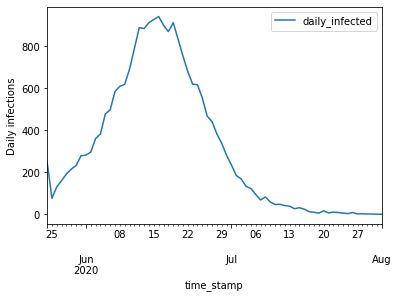

In [55]:
summary.groupby(['time_stamp']).sum().plot(y=['daily_infected'])
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

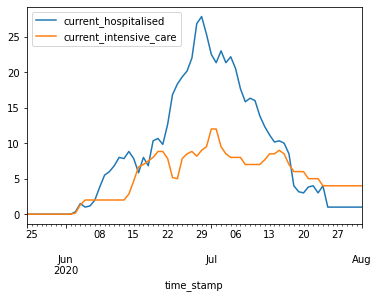

In [56]:
summary.groupby(['time_stamp']).sum().plot(y=['current_hospitalised', 'current_intensive_care'])
plt.show()

### Cumulative infections by age

In [57]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2022-03-08 11:22:46,299 - june.records.records_reader - INFO - Loading infections table
2022-03-08 11:22:46,368 - june.records.records_reader - INFO - Loading population table
2022-03-08 11:22:46,439 - june.records.records_reader - INFO - Merging infection and population tables
2022-03-08 11:22:46,583 - june.records.records_reader - INFO - Loading geography table
2022-03-08 11:22:46,614 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [58]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2022-03-08 11:22:46,649 - june.records.records_reader - INFO - Loading deaths table
2022-03-08 11:22:46,658 - june.records.records_reader - INFO - Loading population table
2022-03-08 11:22:46,718 - june.records.records_reader - INFO - Merging infection and population tables
2022-03-08 11:22:46,722 - june.records.records_reader - INFO - Loading geography table
2022-03-08 11:22:46,749 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [59]:
age_bins = (0,20,60,100)

In [60]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [61]:
people_df = read.table_to_df('population')

In [62]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

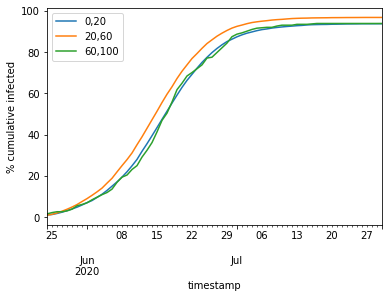

In [63]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("% cumulative infected")
plt.legend()

### Where people get infected

In [64]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

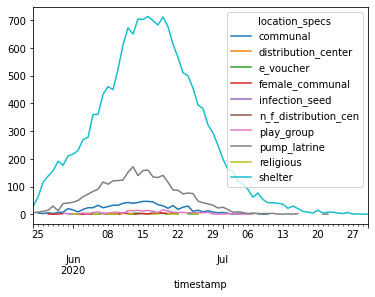

In [65]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

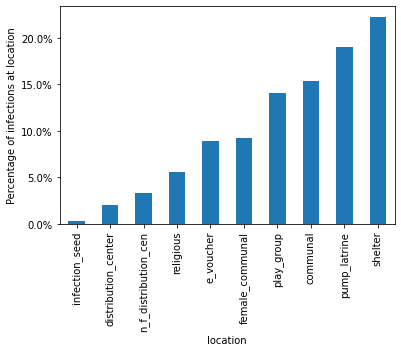

In [66]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')